<a href="https://colab.research.google.com/github/Tookss55/DS/blob/main/Unit5/AmirRegaU5Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

In [ ]:
!pip install pymc arviz

### Unit 5 Project: How does temperature affect ice cream sales?

##### by Amir Regan

### Part 1: Context

Ice cream sales are strongly influenced by different factors, but especially temperature. On warmer days, consumer demand for ice cream tends to increase, while cooler days typically see lower sales. Because ice cream sales can be measured as profit and temperature is a continuous predictor, this dataset fits well within a generalized linear model framework.

In this project, I analyze a real-world dataset taken from Kaggle containing daily temperature measurements and corresponding ice cream sales. I use a Poisson generalized linear model to quantify how temperature affects expected ice cream sales and to capture uncertainty in this relationship using Bayesian inference.

### Part 2: Data

The dataset I pulled from Kaggle gives the daily temperature and daily profits from a small ice cream store. Here's the link to the data set:
https://www.kaggle.com/datasets/raphaelmanayon/temperature-and-ice-cream-sales?resource=download

In [13]:
ice_cream_data = pd.read_csv("https://raw.githubusercontent.com/Tookss55/DS/refs/heads/main/Unit5/Unit5Proj_Data.csv")

In [18]:
ice_cream_data = ice_cream_data.rename(columns={
    "Temperature": "temperature",
    "Ice Cream Profits": "sales"
})

In [19]:
print(ice_cream_data[['temperature', 'sales']].isna().sum())

temperature    0
sales          0
dtype: int64


In [11]:
ice_cream_data

,Temperature,Ice Cream Profits
0,39,13.17
1,40,11.88
2,41,18.82
3,42,18.65
4,43,17.02
...,...,...
360,99,85.13
361,99,87.08
362,99,89.29
363,101,81.91


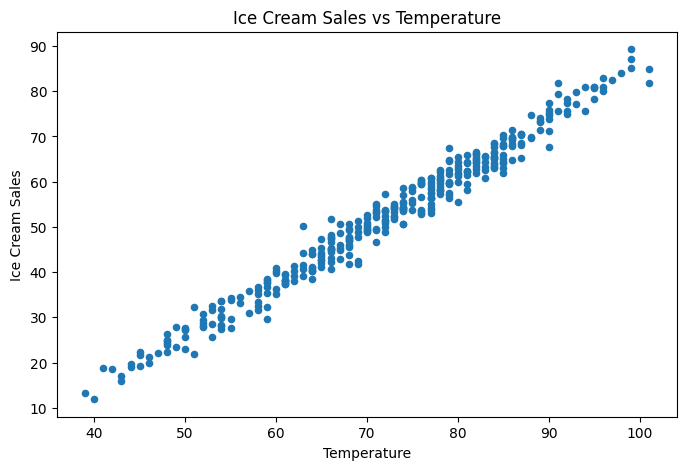

In [22]:
ice_cream_data.plot(
    x="temperature",
    y="sales",
    kind="scatter",
    figsize=(8, 5)
)
plt.xlabel("Temperature")
plt.ylabel("Ice Cream Sales")
plt.title("Ice Cream Sales vs Temperature")
plt.show()

The scatter plot suggests a clear positive relationship between temperature and ice cream sales.

### Part 3: Generalized Linear Model

In [ ]:
with pm.Model() as nh_model:

    # Priors
    α = pm.Normal("α", mu=0, sigma=3)
    β = pm.Normal("β", mu=0, sigma=1)

    # Linear predictor
    mu = α + β * ice_cream_data["temperature"]

    # Log link
    λ = pm.math.exp(mu)

    # Likelihood
    y = pm.Poisson(
        "y_pred",
        mu=λ,
        observed=ice_cream_data["sales"]
    )

    idata_nh = pm.sample(
        2000,
        target_accept=0.9,
        random_seed=42
    )

In [73]:
az.summary(idata_nh)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.148,0.045,2.062,2.233,0.002,0.001,583.0,663.0,1.0
β,0.024,0.001,0.023,0.025,0.000,0.000,582.0,596.0,1.0


A positive posterior mean for β indicates that higher temperatures are associated with increased expected ice cream sales.

In [74]:
temperature_values = ice_cream_data["temperature"].values
idx = np.argsort(temperature_values)

x = np.linspace(
    temperature_values.min(),
    temperature_values.max(),
    100
)

alpha_posterior = idata_nh.posterior["α"]
beta_posterior = idata_nh.posterior["β"]

mu_posterior_pred = (
    alpha_posterior.values[:, :, None]
    + beta_posterior.values[:, :, None] * x[None, None, :]
)

mean_line = np.exp(np.mean(mu_posterior_pred, axis=(0, 1)))


In [ ]:
with nh_model:
    idata_nh.extend(pm.sample_posterior_predictive(idata_nh))

y_pred_q = idata_nh.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75],
    dim=["chain", "draw"]
)

In [76]:
y_hat_bounds_list = []

for i in range(4):
    combined_data = pd.DataFrame({
        "x_val": temperature_values[idx],
        "y_val": y_pred_q[i].values[idx]
    }).groupby("x_val").mean().reset_index()

    interpolator = PchipInterpolator(
        combined_data["x_val"],
        combined_data["y_val"]
    )

    y_hat_bounds_list.append(interpolator(x))

y_hat_bounds = iter(y_hat_bounds_list)

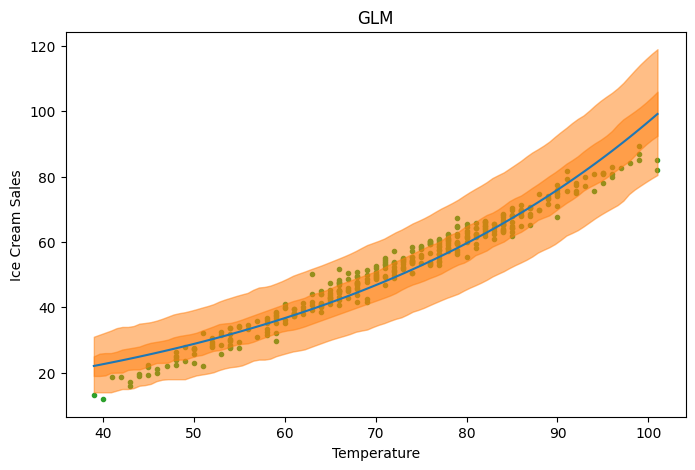

In [77]:
_, ax = plt.subplots(figsize=(8, 5))

ax.plot(
    ice_cream_data["temperature"],
    ice_cream_data["sales"],
    "C2.",
    zorder=-3
)

ax.plot(x, mean_line, c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("Temperature")
ax.set_ylabel("Ice Cream Sales")
ax.set_title("GLM")

plt.show()


### Part 4: Posterior Predictive Check

In [ ]:
pm.sample_posterior_predictive(
    idata_nh,
    model=nh_model,
    extend_inferencedata=True
)


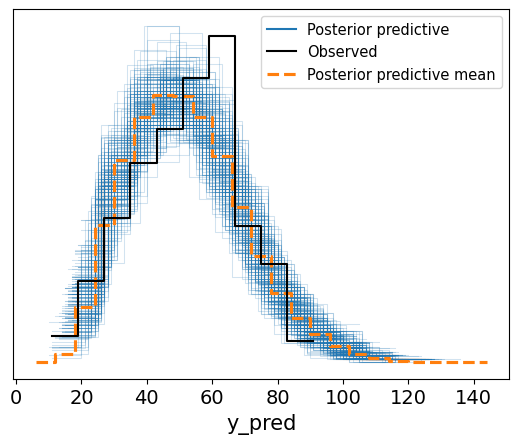

In [79]:
az.plot_ppc(idata_nh, num_pp_samples=200)
plt.show()

The posterior predictive check shows that the observed is pretty well modeled by the GLM, besides the peak of the observed data, so on to the conclusion.

### Part 5: Conclusion

Using a Poisson generalized linear model, this model demonstrates a clear positive relationship between temperature and ice cream sales. As temperature increases, expected ice cream sales rise significantly. The Bayesian framework allows for uncertainty in parameter estimates to be quantified and visualized, providing a more complete understanding of the relationship.